In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")
sns.set(style='darkgrid', font_scale=1.1)

In [2]:
try:
 df = pd.read_csv("fake_bills.csv", sep=';')
 print("Berhasil membaca data")
except Exception as e:
 print(f"Gagal Membaca data as {e}")

Berhasil membaca data


In [3]:
df.shape

(1500, 7)

In [4]:
df.duplicated().sum()

np.int64(0)

In [5]:
df.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [7]:
df['is_genuine'].unique()

array([ True, False])

In [8]:
df['is_genuine'] = df['is_genuine'].astype(int)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   int64  
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 82.2 KB


In [10]:
df['margin_low'] = df['margin_low'].fillna(df['margin_low'].mean())

In [11]:
df.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

<Axes: >

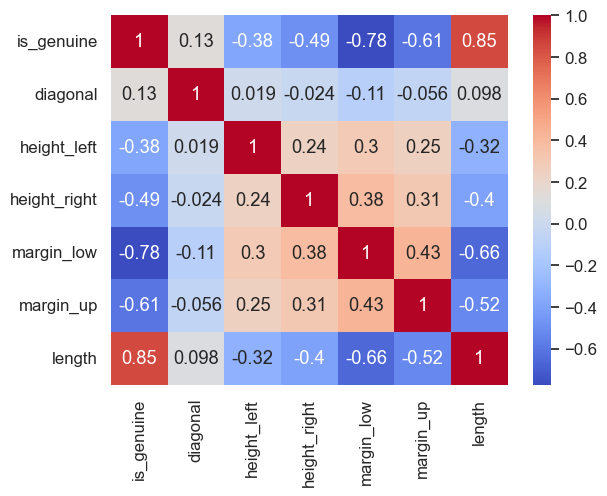

In [12]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

In [13]:
df_major = df[df['is_genuine'] == 1]
df_minor = df[df['is_genuine'] == 0]

target = len(df_major)

df_minor_oversampled = df_minor.sample(n=target, replace=True, random_state=42)

df_final = pd.concat([df_major, df_minor_oversampled])
df_final.shape

(2000, 7)

In [14]:
features = df.drop(columns='is_genuine')
target = df['is_genuine']

In [15]:
features_norm = (features - features.min()) / (features.max() - features.min())
features_norm

,diagonal,height_left,height_right,margin_low,margin_up,length
0,0.390863,0.988506,1.000000,0.392857,0.378049,0.674747
1,0.213198,0.126437,0.394366,0.201531,0.439024,0.727273
2,0.837563,0.770115,0.319249,0.362245,0.408537,0.741414
3,0.162437,0.442529,0.525822,0.163265,0.451220,0.812121
4,0.350254,0.655172,0.300469,0.270408,0.737805,0.616162
...,...,...,...,...,...,...
1495,0.360406,0.712644,0.633803,0.367347,0.500000,0.361616
1496,0.583756,0.856322,0.760563,0.584184,0.670732,0.298990
1497,0.385787,0.500000,0.610329,0.645408,0.664634,0.496970
1498,0.517766,0.655172,0.582160,0.558673,0.725610,0.557576


In [16]:
X_data = features_norm
y_data = target

In [17]:
# fungsi untuk bagi data
def stratified_split_data(X, y, train_size=0.8, random_state=42, frac=None):  # frac untuk menentukan presentase
    np.random.seed(random_state)
    
    if frac:
        X = X.sample(frac=frac, random_state=random_state)
        y = y.loc[X.index]
    
    # buat list kosong untuk data train dan data test
    X_train_list, X_test_list = [], []   
    y_train_list, y_test_list = [], [] 
    
    # mengambil semua nilai unique y dan mengambil mulai dari index 0
    for class_value in np.unique(y):
        class_idx = np.where(y == class_value)[0]
        
        # random  split ratio
        idx = np.random.permutation(class_idx)
        split_ratio = int(len(idx) * train_size)
        
        # menggabungkan data train dan test dengan split ratio
        X_train_list.append(X.iloc[idx[:split_ratio]])
        X_test_list.append(X.iloc[idx[split_ratio:]])
        y_train_list.append(y.iloc[idx[:split_ratio]])
        y_test_list.append(y.iloc[idx[split_ratio:]])

    # menggabungkan list menjadi dataframe 
    X_train = pd.concat(X_train_list).reset_index(drop=True)
    X_test = pd.concat(X_test_list).reset_index(drop=True)
    y_train = pd.concat(y_train_list).reset_index(drop=True)
    y_test = pd.concat(y_test_list).reset_index(drop=True)
    
    # return dataframe tain dan test
    return X_train, X_test, y_train, y_test

# stratified agar data terbai rata (agar data target tetap sama dengan data latih)
X_train, X_test, y_train, y_test = stratified_split_data(X_data, y_data)

In [29]:
class KNN:
    def __init__(self, k, p):
        self.K = k
        self.P = p
        
    def train(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def jarak(self, x1, x2):
        if self.P == 1:
            return np.sum(np.abs(x1 - x2))
        else:
            return np.sqrt(np.sum((x1 - x2) ** 2))
        
    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)
    
    def _predict(self, x):
        jaraks = [self.jarak(x, x_train) for x_train in self.X_train]
        best_k = np.argsort(jaraks)[:self.K]
        label_k = [self.y_train[i] for i in best_k]
        hasil = max(set(label_k), key=label_k.count)
        return hasil

In [19]:
model = KNN(k=3)
model.train(X_train.values, y_train.values)
y_pred_test = model.predict(X_test.values)
y_pred_train = model.predict(X_train.values)

In [33]:
best_acc = 0
best_params = {}

for k in [3, 5, 7, 9]:
    for p in [1, 2]:
        model = KNN(k, p)
        model.train(X_train.values, y_train.values)
        pred = model.predict(X_test.values)
        acc = np.mean(pred == y_test.values)
        
        if acc > best_acc:
            best_acc = acc
            best_params = {'k' : k, 'p' : p}
            
nama_jarak = "Manhattan" if best_params['p'] == 1 else "Euclidean"
print(f"Best K = {best_params['k']} | Jarak = {nama_jarak} | Akurasi = {best_acc}")

Best K = 3 | Jarak = Euclidean | Akurasi = 0.99


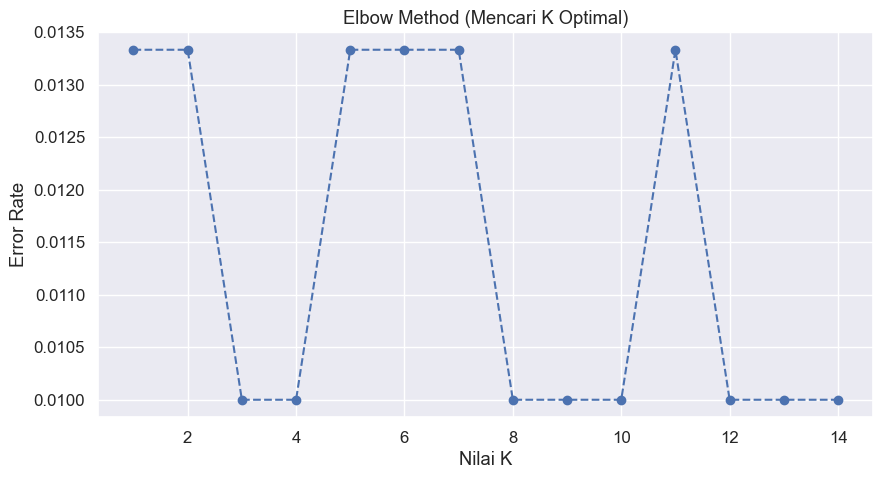

In [20]:
errors = []
range_k = range(1, 15)

for k in range_k:
    model = KNN(k=k)
    model.train(X_train.values, y_train.values)
    pred = model.predict(X_test.values)
    error = np.mean(pred != y_test)
    errors.append(error)

plt.figure(figsize=(10, 5))
plt.plot(range_k, errors, marker='o', linestyle='--')
plt.title('Elbow Method (Mencari K Optimal)')
plt.xlabel('Nilai K')
plt.ylabel('Error Rate')
plt.grid(True)
plt.show()

In [21]:
test_accuracy = np.sum(y_pred_test == y_test) / len(X_test)
test_accuracy

np.float64(0.99)

In [22]:
train_accuracy = np.sum(y_pred_train == y_train) / len(X_train)
train_accuracy

np.float64(0.9933333333333333)

In [23]:
y_pred_array = np.array(y_pred_test)
y_test_array = np.array(y_test)

TP = np.sum((y_pred_array == 1) & (y_test_array == 1))
FP = np.sum((y_pred_array == 1) & (y_test_array == 0))
TN = np.sum((y_pred_array == 0) & (y_test_array == 0))
FN = np.sum((y_pred_array == 0) & (y_test_array == 1))

print(f"True Positive: {TP}")
print(f"False Positive: {FP}")
print(f"True Negative: {TN}")
print(f"False Negative: {FN}")

True Positive: 198
False Positive: 1
True Negative: 99
False Negative: 2


In [24]:
precision = TP / (TP + FP)
precision

np.float64(0.9949748743718593)

In [25]:
recall = TP / (TP + FN)
recall

np.float64(0.99)

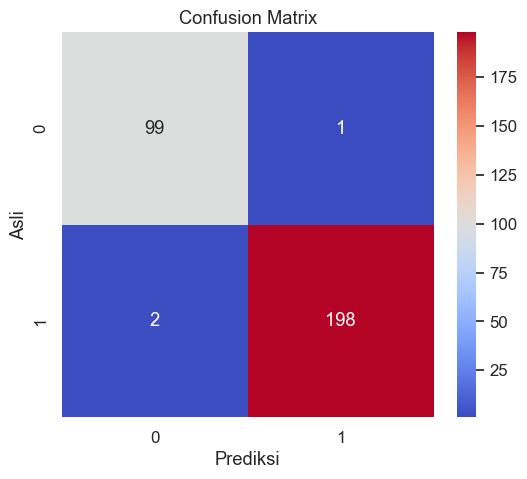

In [26]:
cm = np.array([
    [TN, FP],
    [FN, TP]
])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='d')
plt.xlabel("Prediksi")
plt.ylabel("Asli")
plt.title("Confusion Matrix")
plt.show()

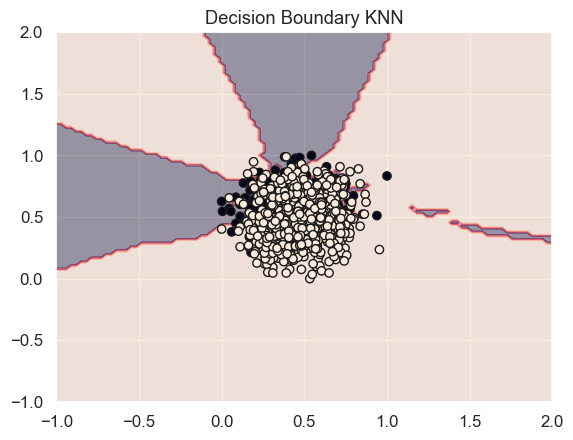

In [35]:
# 1. AMBIL 2 FITUR AJA (Misal kolom ke-0 dan ke-1)
# Kita butuh X baru khusus buat visualisasi
X_vis = X_train.values[:, :2] # Ambil semua baris, kolom 0 & 1
y_vis = y_train.values

# Latih Model KHUSUS Visualisasi (Pake Best K mu tadi)
model_vis = KNN(k=5, p=2)
model_vis.train(X_vis, y_vis)

# 2. BIKIN LANTAI (GRID)
# Cari batas kiri, kanan, bawah, atas (kasih +1 biar lega)
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1

# Bikin jaring-jaring 100x100 titik
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))


# 3. TEBAK WARNA LANTAI
# np.c_ itu cara cepat gabungin titik x dan y
# ravel() buat ngeratain data jadi 1 baris panjang
Z = model_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape) # Balikin bentuknya jadi kotak 100x100

# 4. GAMBAR (Hafalan Standar)
plt.contourf(xx, yy, Z, alpha=0.4) # Gambar Background (Lantai)
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_vis, edgecolors='k') # Gambar Data Asli (Kelereng)
plt.title("Decision Boundary KNN")
plt.show()